Évaluation des résultats de lemmatisation 
==================================

## Objectifs

1. Lecture des logs
2. Alignement avec types de modèles
3. Lectures des résultats

## Data acquisition

In [1]:
import glob
import copy
from pandas import DataFrame

# IMPORTANT: THIS IS HARD CODED, SUPPORT FOR ALL LEMMA FROM DEV SET

nb_words_dev_set = 40812


ModelScheme = {
    "config": "",
    "tar": "",
}
file = "./logs/single-tasks.log"

def parse_lines(lines, task_prefix="## ", is_file=True):
    models = []
    tasks = []
    config = None
    current_task = None
    template = {
        "scores": {},
        "eval-time": [],
        "optimizer": "adam"
    }
    current = copy.deepcopy(template)
    for line in lines:
        if is_file and line.startswith("config_path: "):
            current["config"] = line.strip()[len("config_path: "):]
        elif is_file and line.startswith("cemb_dim: "):
            current["cemb_dim"] = line.strip()[len("cemb_dim: "):]
        elif is_file and line.startswith("cell: "):
            current["cell"] = line.strip()[len("cell: "):]
        elif is_file and line.startswith("hidden_size: "):
            current["hidden_size"] = line.strip()[len("hidden_size: "):]
        elif is_file and line.startswith("optimizer: "):
            current["optimizer"] = line.strip()[len("optimizer: "):]
        elif is_file and "Bye" in line.strip():
            models.append(current)
            current = copy.deepcopy(template)
            current_task = None
        elif line.startswith(task_prefix):
            current_task = line.strip()[len(task_prefix):]
            tasks.append(current_task)
            current["scores"][current_task] = {}
            current["task"] = current_task
        elif current_task and line.startswith("|"):  # We already have a task recorded
            cat, acc, pre, rec, sup = [x.strip() for x in line.strip().split("|") if x]
            if sup == "support" or "---" in sup:
                continue
            current["scores"][current_task][cat] = (float(acc)*100, float(pre)*100, float(rec)*100, int(sup))
        elif is_file and ".tar" in line:
            current["file"] = line.strip()[len("Saved best model to: ["):-1]
        #elif is_file and "Finished training in " in line:
        #    current["training-time"] = float(line.strip()[len("2020-04-23 23:13:33,251 : Finished training in ["):-1])
        #elif is_file and "Starting epoch" in line:
        #    current["nb-epochs"] = int(line.strip()[len("2020-04-23 20:23:00,051 : Starting epoch ["):-1])
        #elif is_file and "Evaluation time: " in line:
        #    current["eval-time"].append(
        #        float(line.strip()[len("2020-04-24 04:04:56,425 : Evaluation time: "):-len(" sec")])
        #    )
    if not is_file:
        current["file"] = f"default-{len(models)}"
        models.append(current)
    models = {
        model.get("file", "default"): model for model in models
    }
    tasks = {
        task: [model for model in models.values() if model["task"] == task]
        for task in tasks
    }
    return models, tasks

with open(file) as f:
    _, tasks = parse_lines(f)

with open("./logs/single-tasks-lemma-try.log") as f:
    for task, models in parse_lines(f)[1].items():
        tasks[task].extend([
            model
            for model in models
            if model["file"] == "./models/latin-upvc-single-lemma-complexe5-lemma-2021_03_01-00_30_57.tar"
        ])


## Reference score

In [2]:
REF = """
## lemma

|                  | accuracy | precision | recall | support |
|------------------|----------|-----------|--------|---------|
| all              | 0.972    | 0.82      | 0.8138 | 169819  |
| known-tokens     | 0.9768   | 0.8901    | 0.8878 | 161865  |
| unknown-tokens   | 0.8736   | 0.7299    | 0.7254 | 7954    |
| ambiguous-tokens | 0.9264   | 0.6885    | 0.6953 | 42700   |
| unknown-targets  | 0.6304   | 0.464     | 0.4619 | 1104    |


## pos

|                  | accuracy | precision | recall | support |
|------------------|----------|-----------|--------|---------|
| all              | 0.9611   | 0.938     | 0.9271 | 169819  |
| known-tokens     | 0.9641   | 0.9462    | 0.9312 | 161865  |
| unknown-tokens   | 0.9017   | 0.6995    | 0.6657 | 7954    |
| ambiguous-tokens | 0.9031   | 0.8792    | 0.8432 | 52025   |


## Gend

|                  | accuracy | precision | recall | support |
|------------------|----------|-----------|--------|---------|
| all              | 0.9631   | 0.9107    | 0.9138 | 169819  |
| known-tokens     | 0.9656   | 0.9145    | 0.9192 | 161865  |
| unknown-tokens   | 0.9125   | 0.8507    | 0.8357 | 7954    |
| ambiguous-tokens | 0.8796   | 0.8799    | 0.8891 | 40191   |


## Numb

|                  | accuracy | precision | recall | support |
|------------------|----------|-----------|--------|---------|
| all              | 0.9718   | 0.9702    | 0.9698 | 169819  |
| known-tokens     | 0.9734   | 0.9717    | 0.9712 | 161865  |
| unknown-tokens   | 0.9395   | 0.9094    | 0.9196 | 7954    |
| ambiguous-tokens | 0.9086   | 0.9051    | 0.9019 | 39600   |


## Case

|                  | accuracy | precision | recall | support |
|------------------|----------|-----------|--------|---------|
| all              | 0.9219   | 0.8863    | 0.8198 | 169819  |
| known-tokens     | 0.9243   | 0.8919    | 0.8262 | 161865  |
| unknown-tokens   | 0.8726   | 0.6355    | 0.6256 | 7954    |
| ambiguous-tokens | 0.8318   | 0.8454    | 0.7857 | 64272   |


## Deg

|                  | accuracy | precision | recall | support |
|------------------|----------|-----------|--------|---------|
| all              | 0.9799   | 0.968     | 0.9703 | 169819  |
| known-tokens     | 0.9822   | 0.9702    | 0.9751 | 161865  |
| unknown-tokens   | 0.933    | 0.9246    | 0.8993 | 7954    |
| ambiguous-tokens | 0.9197   | 0.9188    | 0.9332 | 29785   |


## Mood_Tense_Voice

|                  | accuracy | precision | recall | support |
|------------------|----------|-----------|--------|---------|
| all              | 0.9822   | 0.7717    | 0.6944 | 169819  |
| known-tokens     | 0.9857   | 0.7829    | 0.711  | 161865  |
| unknown-tokens   | 0.911    | 0.6222    | 0.5942 | 7954    |
| ambiguous-tokens | 0.9222   | 0.6828    | 0.6701 | 17876   |


## Person

|                  | accuracy | precision | recall | support |
|------------------|----------|-----------|--------|---------|
| all              | 0.9971   | 0.9879    | 0.9768 | 169819  |
| known-tokens     | 0.9979   | 0.9893    | 0.9822 | 161865  |
| unknown-tokens   | 0.9821   | 0.976     | 0.9461 | 7954    |
| ambiguous-tokens | 0.9788   | 0.9416    | 0.9223 | 10188   |


## Dis

|                  | accuracy | precision | recall | support |
|------------------|----------|-----------|--------|---------|
| all              | 0.9716   | 0.8677    | 0.8749 | 169819  |
| known-tokens     | 0.973    | 0.8691    | 0.8783 | 161865  |
| unknown-tokens   | 0.9439   | 0.6508    | 0.5098 | 7954    |
| ambiguous-tokens | 0.9126   | 0.8507    | 0.8618 | 43148   |

""".split("\n")

ref, ref_tasks = parse_lines(REF, "## ", is_file=False)

## Tabulate data

In [3]:
column = [
    "file", "task", "config",
    "optimizer", "cell", "hidden", "cemb",
    "score",
    *[
        f"{'-'.join([x[:3] for x in cat.split('-')])}-{score[:3]}"
        for cat in tasks["lemma"][0]["scores"]["lemma"]
        for score in ("acc", "prec", "rec")
    ],
    *[
        f"rank-{'-'.join([x[:3] for x in cat.split('-')])}-{score[:3]}"
        for cat in tasks["lemma"][0]["scores"]["lemma"]
        for score in ("acc", "prec", "rec")
    ]
]

#files = sorted(list(models.keys()))

table = []
for task, files in tasks.items():
    for model in files:
        table.append([
            model["file"],
            task,
            f'{model["optimizer"]}-{model["cell"]}-H{model["hidden_size"]}-C{model["cemb_dim"]}',
            model["optimizer"],
            model["cell"],
            model["hidden_size"],
            model["cemb_dim"],
            .0, # Future Ranking Score
            # Scores
            *[
                score
                for cat in tasks["lemma"][0]["scores"]["lemma"]
                for score in model["scores"][task].get(cat, [.0, .0, .0])[:3]
            ],
            *[
                .0
                for cat in tasks["lemma"][0]["scores"]["lemma"]
                for score in model["scores"][task].get(cat, [.0, .0, .0])[:3]
            ]
        ])
    
table = sorted(table, key=lambda x: f"{x[1]}.{x[7]*100:.2f}")  # 2 is acc, 3 amb, 5 tokens
table = [column] + table

In [4]:
# Create a table like representation
import tabulate
from IPython.display import HTML, display

display(HTML(tabulate.tabulate(table, floatfmt=":,2f", tablefmt='html')))

file,task,config,optimizer,cell,hidden,cemb,score,all-acc,all-pre,all-rec,kno-tok-acc,kno-tok-pre,kno-tok-rec,unk-tok-acc,unk-tok-pre,unk-tok-rec,amb-tok-acc,amb-tok-pre,amb-tok-rec,unk-tar-acc,unk-tar-pre,unk-tar-rec,rank-all-acc,rank-all-pre,rank-all-rec,rank-kno-tok-acc,rank-kno-tok-pre,rank-kno-tok-rec,rank-unk-tok-acc,rank-unk-tok-pre,rank-unk-tok-rec,rank-amb-tok-acc,rank-amb-tok-pre,rank-amb-tok-rec,rank-unk-tar-acc,rank-unk-tar-pre,rank-unk-tar-rec
./models/latin-upvc-single-Case-Case-2021_02_20-16_15_57.tar,Case,Adam-LSTM-H300-C150,Adam,LSTM,300,150,0.0,94.64,90.38000000000001,88.82,94.86,91.05,89.56,90.18,74.51,70.96000000000001,88.53,87.46000000000001,86.19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
./models/latin-upvc-single-Case-Case-2021_02_20-21_58_02.tar,Case,Adam-LSTM-H300-C150,Adam,LSTM,300,150,0.0,94.67,89.95,87.87,94.89,90.78,88.47,90.24,72.28,76.57000000000001,88.62,87.39,85.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
./models/latin-upvc-single-Case-Case-2021_02_21-02_44_51.tar,Case,Adam-LSTM-H300-C150,Adam,LSTM,300,150,0.0,94.15,91.0,86.33999999999999,94.41000000000001,91.72,86.92999999999999,88.82,67.7,65.4,87.74,87.86,83.91999999999999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
./models/latin-upvc-single-Case-Case-2021_02_21-08_12_00.tar,Case,Adam-LSTM-H300-C150,Adam,LSTM,300,150,0.0,94.28,90.75,86.88,94.52000000000001,91.38,87.6,89.42999999999999,77.44,70.47,88.0,87.94,84.86,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
./models/latin-upvc-single-Case-Case-2021_02_21-13_11_09.tar,Case,Adam-LSTM-H300-C150,Adam,LSTM,300,150,0.0,94.43,89.57000000000001,87.77000000000001,94.69,90.64999999999999,88.46000000000001,89.28,71.39999999999999,71.50999999999999,88.23,87.49,84.91,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
./models/latin-upvc-single-Case-Case-2021_02_21-18_41_40.tar,Case,Adam-LSTM-H300-C150,Adam,LSTM,300,150,0.0,94.63000000000001,91.10000000000001,87.47,94.87,91.97999999999999,88.06,89.67,77.44,70.03,88.5,88.05,85.17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
./models/latin-upvc-single-Case-Case-2021_02_21-23_25_31.tar,Case,Adam-LSTM-H300-C150,Adam,LSTM,300,150,0.0,94.54,90.88000000000001,87.72999999999999,94.77,91.33,88.32,89.89,77.91,76.75,88.39,87.94,85.38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
./models/latin-upvc-single-Case-Case-2021_02_22-04_46_10.tar,Case,Adam-LSTM-H300-C150,Adam,LSTM,300,150,0.0,94.32000000000001,89.62,88.06,94.56,90.16999999999999,88.53999999999999,89.45,80.55,79.05,87.96000000000001,86.63,85.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
./models/latin-upvc-single-Case-Case-2021_02_22-10_10_50.tar,Case,Adam-LSTM-H300-C150,Adam,LSTM,300,150,0.0,94.12,90.36,87.02,94.37,91.05,87.69,89.14,68.19,73.76,87.62,87.25,84.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
./models/latin-upvc-single-Deg-Deg-2021_02_20-16_34_37.tar,Deg,Adam-LSTM-H300-C150,Adam,LSTM,300,150,0.0,98.31,97.49,97.39,98.5,97.75,97.71,94.42,93.15,92.14,93.24,93.67999999999999,93.71000000000001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
with open("3 - Optimisation des Modeles - Entrainement comme tache unique - Models - Full.csv", "w") as f:
    import csv
    writer = csv.writer(f)
    writer.writerows(table)

# Attempt at ranking

In [6]:
ranks = DataFrame(
    [x[1:] for x in table[1:]],
    columns=column[1:],
    index=[x[0] for x in table[1:]]
)
needs_ranking = column[8:column.index('rank-all-acc')]
    
for task in tasks:
    ranking_subset = needs_ranking if task == "lemma" else needs_ranking[:-3]
    for col in ranking_subset:
        #ranks[f"rank-{col}"] = ranks[col].rank(ascending=False)
        ranks[f"rank-{col}"] += ranks.where(ranks['task'].eq(task))[col].rank(ascending=False).fillna(0)

    #ranks["score"] = sum(
    #    ranks.where(ranks['task'].eq(task))[[f"rank-{col}" for col in needs_ranking]].fillna(0)
    #) / len(ranking_subset)

ranks["score"] += (sum([ranks[f"rank-{col}"].where(ranks['task'].eq("lemma")) for col in needs_ranking]) / (len(needs_ranking))).fillna(0)
ranks["score"] += (sum([ranks[f"rank-{col}"].where(ranks['task'].ne("lemma")) for col in needs_ranking]) / (len(needs_ranking)-3)).fillna(0)

ranks.to_csv("3 - Optimisation des Modeles - Entrainement comme tache unique - Models - Experiment Ranger Adams Hidden - Ranks.csv")

In [7]:
display(HTML(ranks.sort_values(["task", "score"]).to_html()))

,task,config,optimizer,cell,hidden,cemb,score,all-acc,all-pre,all-rec,kno-tok-acc,kno-tok-pre,kno-tok-rec,unk-tok-acc,unk-tok-pre,unk-tok-rec,amb-tok-acc,amb-tok-pre,amb-tok-rec,unk-tar-acc,unk-tar-pre,unk-tar-rec,rank-all-acc,rank-all-pre,rank-all-rec,rank-kno-tok-acc,rank-kno-tok-pre,rank-kno-tok-rec,rank-unk-tok-acc,rank-unk-tok-pre,rank-unk-tok-rec,rank-amb-tok-acc,rank-amb-tok-pre,rank-amb-tok-rec,rank-unk-tar-acc,rank-unk-tar-pre,rank-unk-tar-rec
./models/latin-upvc-single-Case-Case-2021_02_20-16_15_57.tar,Case,Adam-LSTM-H300-C150,Adam,LSTM,300,150,3.291667,94.64,90.38,88.82,94.86,91.05,89.56,90.18,74.51,70.96,88.53,87.46,86.19,0.00,0.00,0.00,2.0,5.0,1.0,3.0,5.5,1.0,2.0,5.0,6.0,2.0,6.0,1.0,0.0,0.0,0.0
./models/latin-upvc-single-Case-Case-2021_02_21-23_25_31.tar,Case,Adam-LSTM-H300-C150,Adam,LSTM,300,150,3.458333,94.54,90.88,87.73,94.77,91.33,88.32,89.89,77.91,76.75,88.39,87.94,85.38,0.00,0.00,0.00,4.0,3.0,5.0,4.0,4.0,5.0,3.0,2.0,2.0,4.0,2.5,3.0,0.0,0.0,0.0
./models/latin-upvc-single-Case-Case-2021_02_21-18_41_40.tar,Case,Adam-LSTM-H300-C150,Adam,LSTM,300,150,3.625000,94.63,91.10,87.47,94.87,91.98,88.06,89.67,77.44,70.03,88.50,88.05,85.17,0.00,0.00,0.00,3.0,1.0,6.0,2.0,1.0,6.0,4.0,3.5,8.0,3.0,1.0,5.0,0.0,0.0,0.0
./models/latin-upvc-single-Case-Case-2021_02_20-21_58_02.tar,Case,Adam-LSTM-H300-C150,Adam,LSTM,300,150,3.666667,94.67,89.95,87.87,94.89,90.78,88.47,90.24,72.28,76.57,88.62,87.39,85.25,0.00,0.00,0.00,1.0,7.0,3.0,1.0,7.0,3.0,1.0,6.0,3.0,1.0,7.0,4.0,0.0,0.0,0.0
./models/latin-upvc-single-Case-Case-2021_02_22-04_46_10.tar,Case,Adam-LSTM-H300-C150,Adam,LSTM,300,150,4.833333,94.32,89.62,88.06,94.56,90.17,88.54,89.45,80.55,79.05,87.96,86.63,85.60,0.00,0.00,0.00,6.0,8.0,2.0,6.0,9.0,2.0,5.0,1.0,1.0,7.0,9.0,2.0,0.0,0.0,0.0
./models/latin-upvc-single-Case-Case-2021_02_21-08_12_00.tar,Case,Adam-LSTM-H300-C150,Adam,LSTM,300,150,5.750000,94.28,90.75,86.88,94.52,91.38,87.60,89.43,77.44,70.47,88.00,87.94,84.86,0.00,0.00,0.00,7.0,4.0,8.0,7.0,3.0,8.0,6.0,3.5,7.0,6.0,2.5,7.0,0.0,0.0,0.0
./models/latin-upvc-single-Case-Case-2021_02_21-13_11_09.tar,Case,Adam-LSTM-H300-C150,Adam,LSTM,300,150,5.833333,94.43,89.57,87.77,94.69,90.65,88.46,89.28,71.40,71.51,88.23,87.49,84.91,0.00,0.00,0.00,5.0,9.0,4.0,5.0,8.0,4.0,7.0,7.0,5.0,5.0,5.0,6.0,0.0,0.0,0.0
./models/latin-upvc-single-Case-Case-2021_02_21-02_44_51.tar,Case,Adam-LSTM-H300-C150,Adam,LSTM,300,150,7.166667,94.15,91.00,86.34,94.41,91.72,86.93,88.82,67.70,65.40,87.74,87.86,83.92,0.00,0.00,0.00,8.0,2.0,9.0,8.0,2.0,9.0,9.0,9.0,9.0,8.0,4.0,9.0,0.0,0.0,0.0
./models/latin-upvc-single-Case-Case-2021_02_22-10_10_50.tar,Case,Adam-LSTM-H300-C150,Adam,LSTM,300,150,7.375000,94.12,90.36,87.02,94.37,91.05,87.69,89.14,68.19,73.76,87.62,87.25,84.30,0.00,0.00,0.00,9.0,6.0,7.0,9.0,5.5,7.0,8.0,8.0,4.0,9.0,8.0,8.0,0.0,0.0,0.0
./models/latin-upvc-single-Deg-Deg-2021_02_21-08_52_32.tar,Deg,Adam-LSTM-H300-C150,Adam,LSTM,300,150,1.583333,98.41,97.61,97.83,98.59,97.78,98.10,94.72,94.20,93.23,93.57,93.78,94.69,0.00,0.00,0.00,1.0,1.0,2.0,1.0,1.0,2.0,2.0,4.0,1.0,1.0,1.0,2.0,0.0,0.0,0.0


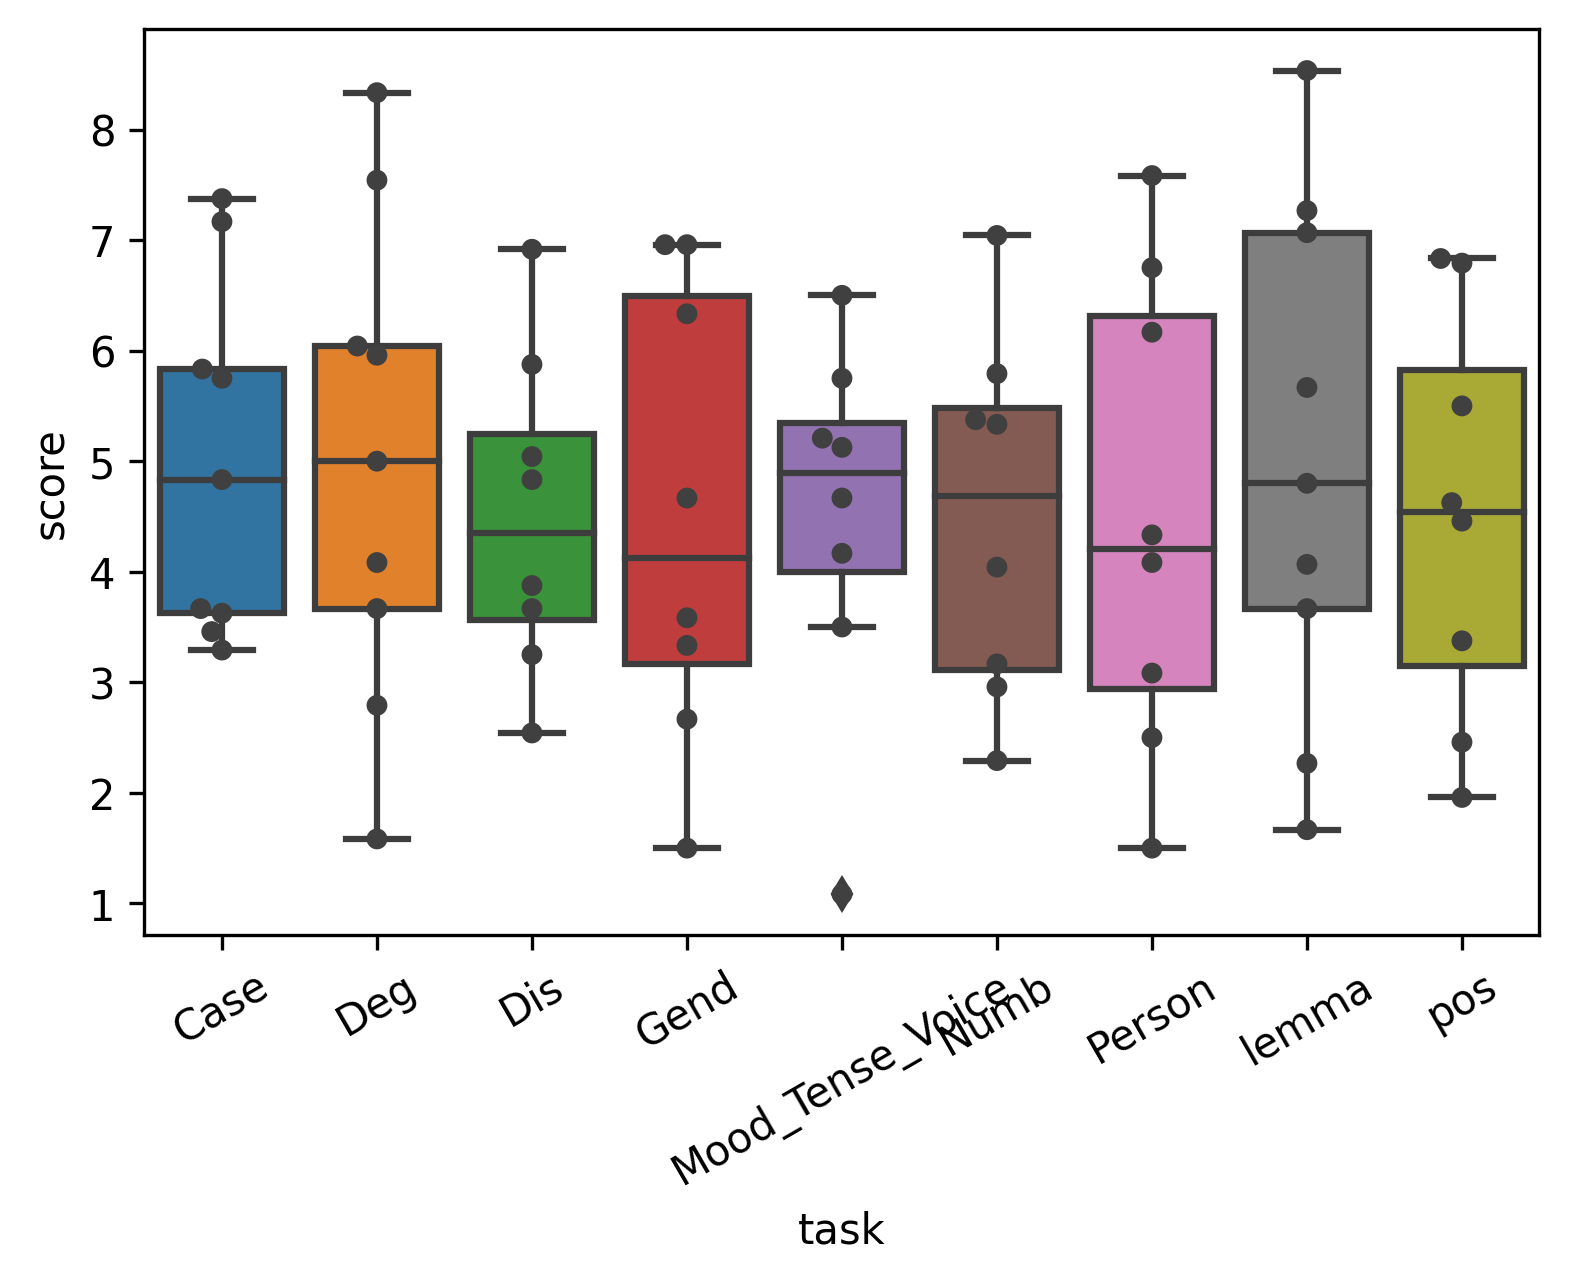

In [8]:
import seaborn as sns


ax = sns.boxplot(y="score", x="task", data=ranks[ranks.score < 20])
ax = sns.swarmplot(y="score", x="task", data=ranks[ranks.score < 20], color=".25")
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
ax.figure.set_dpi(300)

# Evaluating against current best-model

In [9]:
ref_score = {
    task: tuple([
            score
            for cat in model["scores"][task]
            for score in model["scores"][task][cat][:3]
        ]
    )
    for model in ref.values()
    for task in model["scores"]
}

In [10]:
for task in tasks:
    need_diff = column[8:column.index('rank-all-acc')]
    need_diff = need_diff if task == "lemma" else need_diff[:-3]
    
    cols = [
        f"{'-'.join([x[:3] for x in cat.split('-')])}-{score[:3]}"
        for cat in tasks[task][0]["scores"][task]
        for score in ("acc", "prec", "rec")
    ]
    for cat, r in zip(cols, ref_score[task]):
        if f"diff-{cat}" not in ranks.columns:
            ranks[f"diff-{cat}"] = 0
        ranks[f"diff-{cat}"] += (ranks[cat].where(ranks['task'].eq(task)) - r).fillna(0)

# Evaluating (un)stability

<ipython-input-11-dc8950b07c54>:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


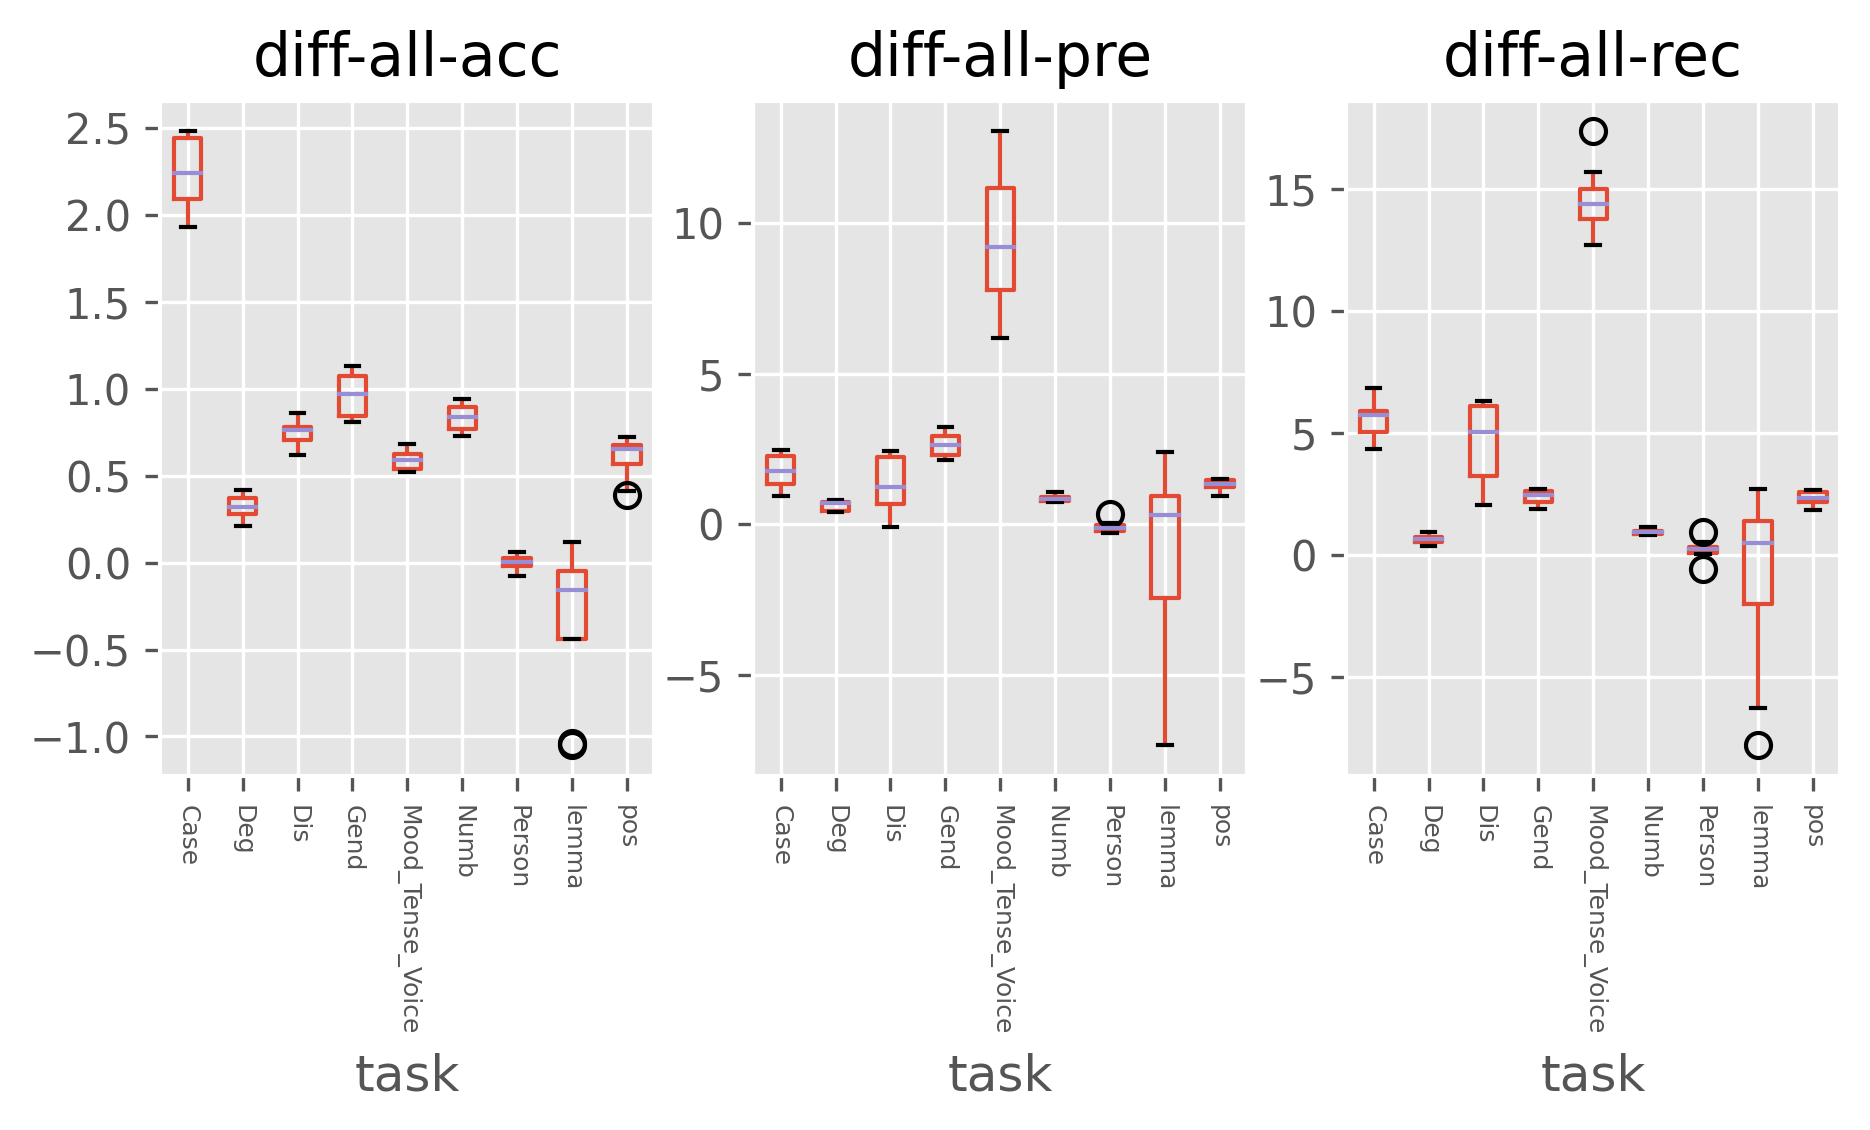

In [11]:
import matplotlib.pyplot as plt    

plt.style.use('ggplot')
plt.rc('xtick', labelsize=6)    # fontsize of the tick labels
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(7,3), dpi=300)#, sharey=True)
ranks.boxplot(column="diff-all-acc", by="task", ax=ax1, vert=True, rot=-90)
ranks.boxplot(column="diff-all-pre", by="task", ax=ax2, vert=True, rot=-90)
ranks.boxplot(column="diff-all-rec", by="task", ax=ax3, vert=True, rot=-90)
fig.suptitle("")
fig.show()

<ipython-input-12-7ea1968d5674>:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


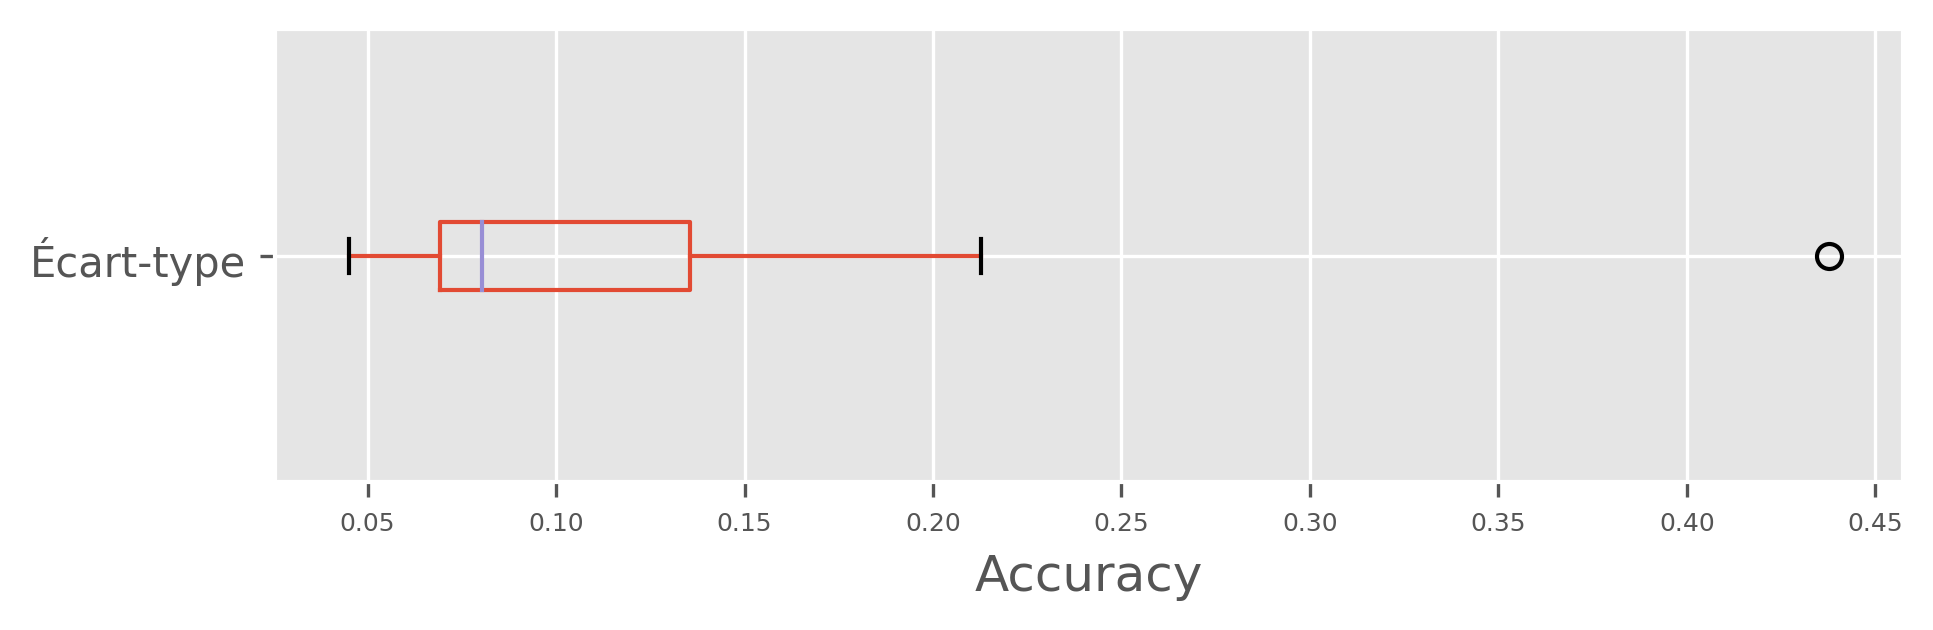

In [12]:
from pandas import Series

fig = plt.figure(figsize=(7,2), dpi=300)
ax = fig.gca()
serie = Series((ranks.groupby("task")["all-acc"].std()).tolist(), name="Écart-type")
ax = serie.plot.box(ax=ax, vert=False)#*100
ax.set_xlabel("Accuracy")
fig.show()

# Keeping the best model only

In [13]:
bests = ranks.copy().sort_values("score").drop_duplicates("task")

In [14]:
display(HTML(
    bests
        .sort_values("task")
        .to_html()
))

,task,config,optimizer,cell,hidden,cemb,score,all-acc,all-pre,all-rec,kno-tok-acc,kno-tok-pre,kno-tok-rec,unk-tok-acc,unk-tok-pre,unk-tok-rec,amb-tok-acc,amb-tok-pre,amb-tok-rec,unk-tar-acc,unk-tar-pre,unk-tar-rec,rank-all-acc,rank-all-pre,rank-all-rec,rank-kno-tok-acc,rank-kno-tok-pre,rank-kno-tok-rec,rank-unk-tok-acc,rank-unk-tok-pre,rank-unk-tok-rec,rank-amb-tok-acc,rank-amb-tok-pre,rank-amb-tok-rec,rank-unk-tar-acc,rank-unk-tar-pre,rank-unk-tar-rec,diff-all-acc,diff-all-pre,diff-all-rec,diff-kno-tok-acc,diff-kno-tok-pre,diff-kno-tok-rec,diff-unk-tok-acc,diff-unk-tok-pre,diff-unk-tok-rec,diff-amb-tok-acc,diff-amb-tok-pre,diff-amb-tok-rec,diff-unk-tar-acc,diff-unk-tar-pre,diff-unk-tar-rec
./models/latin-upvc-single-Case-Case-2021_02_20-16_15_57.tar,Case,Adam-LSTM-H300-C150,Adam,LSTM,300,150,3.291667,94.64,90.38,88.82,94.86,91.05,89.56,90.18,74.51,70.96,88.53,87.46,86.19,0.00,0.0,0.00,2.0,5.0,1.0,3.0,5.5,1.0,2.0,5.0,6.0,2.0,6.0,1.0,0.0,0.0,0.0,2.45,1.75,6.84,2.43,1.86,6.94,2.92,10.96,8.40,5.35,2.92,7.62,0.00,0.0,0.00
./models/latin-upvc-single-Deg-Deg-2021_02_21-08_52_32.tar,Deg,Adam-LSTM-H300-C150,Adam,LSTM,300,150,1.583333,98.41,97.61,97.83,98.59,97.78,98.10,94.72,94.20,93.23,93.57,93.78,94.69,0.00,0.0,0.00,1.0,1.0,2.0,1.0,1.0,2.0,2.0,4.0,1.0,1.0,1.0,2.0,0.0,0.0,0.0,0.42,0.81,0.80,0.37,0.76,0.59,1.42,1.74,3.30,1.60,1.90,1.37,0.00,0.0,0.00
./models/latin-upvc-single-Dis-Dis-2021_02_21-09_20_46.tar,Dis,Adam-LSTM-H300-C150,Adam,LSTM,300,150,2.541667,97.93,89.08,93.73,97.98,89.15,93.85,97.05,70.66,67.94,92.97,87.68,92.04,0.00,0.0,0.00,3.5,2.0,2.0,4.0,2.0,2.0,2.0,2.0,2.0,4.0,2.0,3.0,0.0,0.0,0.0,0.77,2.31,6.24,0.68,2.24,6.02,2.66,5.58,16.96,1.71,2.61,5.86,0.00,0.0,0.00
./models/latin-upvc-single-Gend-Gend-2021_02_20-17_47_26.tar,Gend,Adam-LSTM-H300-C150,Adam,LSTM,300,150,1.500000,97.44,94.29,93.99,97.63,94.55,94.39,93.50,90.09,88.15,91.71,92.12,92.14,0.00,0.0,0.00,1.0,1.0,3.0,1.0,1.0,3.0,1.0,1.0,2.0,1.0,1.0,2.0,0.0,0.0,0.0,1.13,3.22,2.61,1.07,3.10,2.47,2.25,5.02,4.58,3.75,4.13,3.23,0.00,0.0,0.00
./models/latin-upvc-single-Mood_Tense_Voice-Mood_Tense_Voice-2021_02_21-00_47_55.tar,Mood_Tense_Voice,Adam-LSTM-H300-C150,Adam,LSTM,300,150,1.083333,98.90,90.21,86.81,99.07,90.88,88.88,95.37,81.31,83.74,93.91,83.72,82.34,0.00,0.0,0.00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,0.0,0.0,0.0,0.68,13.04,17.37,0.50,12.59,17.78,4.27,19.09,24.32,1.69,15.44,15.33,0.00,0.0,0.00
./models/latin-upvc-single-Numb-Numb-2021_02_20-20_34_55.tar,Numb,Adam-LSTM-H300-C150,Adam,LSTM,300,150,2.291667,98.12,98.10,97.92,98.26,98.24,98.06,95.30,93.68,93.33,93.87,93.83,93.33,0.00,0.0,0.00,1.0,1.0,4.5,1.0,1.0,4.0,2.0,1.0,4.0,1.0,1.0,6.0,0.0,0.0,0.0,0.94,1.08,0.94,0.92,1.07,0.94,1.35,2.74,1.37,3.01,3.32,3.14,0.00,0.0,0.00
./models/latin-upvc-single-Person-Person-2021_02_21-01_42_59.tar,Person,Adam-LSTM-H300-C150,Adam,LSTM,300,150,1.500000,99.77,99.12,98.20,99.83,99.25,98.64,98.49,98.05,95.65,98.29,96.08,93.33,0.00,0.0,0.00,1.0,1.0,2.0,1.0,1.0,2.0,2.0,1.0,2.0,1.0,1.0,3.0,0.0,0.0,0.0,0.06,0.33,0.52,0.04,0.32,0.42,0.28,0.45,1.04,0.41,1.92,1.10,0.00,0.0,0.00
./models/latin-upvc-single-lemma-complexe5-lemma-2021_03_01-00_30_57.tar,lemma,Ranger-LSTM-H128-C300,Ranger,LSTM,128,300,1.666667,97.32,84.41,84.09,97.72,90.53,90.52,89.23,76.31,75.96,92.56,69.62,70.30,62.05,45.1,44.96,1.0,1.0,1.0,2.0,2.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,3.0,3.0,3.0,0.12,2.41,2.71,0.04,1.52,1.74,1.87,3.32,3.42,-0.08,0.77,0.77,-0.99,-1.3,-1.23
./models/latin-upvc-single-pos-pos-2021_02_21-12_40_18.tar,pos,Adam-LSTM-H300-C150,Adam,LSTM,300,150,1.958333,96.80,95.29,95.27,97.08,95.90,95.50,91.22,73.59,77.73,92.07,90.82,89.50,0.00,0.0,0.00,2.0,1.0,3.0,1.5,2.0,2.0,5.0,1.0,2.0,1.0,2.0,1.0,0.0,0.0,0.0,0.69,1.49,2.56,0.67,1.28,2.38,1.05,3.64,11.16,1.76,2.90,5.18,0.00,0.0,0.00


In [27]:
for index, values in bests.iterrows():
    print(f"cp {index} bests/upvc/lasla-plus-{values['task']}.tar")
    
for index, values in bests.iterrows():
    print(f"""File("https://github.com/PonteIneptique/latin-lasla-models/releases/download/"+VERSION+"/lasla-plus-{values['task']}.tar",
    "{values['task']}.tar")""")

for index, values in bests.iterrows():
    print(""""<{},"""+values['task']+f""">".format(get_path("lasla", "{values['task']}")),""")

cp ./models/latin-upvc-single-Mood_Tense_Voice-Mood_Tense_Voice-2021_02_21-00_47_55.tar bests/upvc/lasla-plus-Mood_Tense_Voice.tar
cp ./models/latin-upvc-single-Gend-Gend-2021_02_20-17_47_26.tar bests/upvc/lasla-plus-Gend.tar
cp ./models/latin-upvc-single-Person-Person-2021_02_21-01_42_59.tar bests/upvc/lasla-plus-Person.tar
cp ./models/latin-upvc-single-Deg-Deg-2021_02_21-08_52_32.tar bests/upvc/lasla-plus-Deg.tar
cp ./models/latin-upvc-single-lemma-complexe5-lemma-2021_03_01-00_30_57.tar bests/upvc/lasla-plus-lemma.tar
cp ./models/latin-upvc-single-pos-pos-2021_02_21-12_40_18.tar bests/upvc/lasla-plus-pos.tar
cp ./models/latin-upvc-single-Numb-Numb-2021_02_20-20_34_55.tar bests/upvc/lasla-plus-Numb.tar
cp ./models/latin-upvc-single-Dis-Dis-2021_02_21-09_20_46.tar bests/upvc/lasla-plus-Dis.tar
cp ./models/latin-upvc-single-Case-Case-2021_02_20-16_15_57.tar bests/upvc/lasla-plus-Case.tar
File("https://github.com/PonteIneptique/latin-lasla-models/releases/download/"+VERSION+"/lasla-plus

## Comparing Configurations

In [22]:
def nice_columns(matrix, cols):
    beautiful = {
        "kno-tok": "Known tokens",
        "unk-tok": "Unknown tokens",
        "amb-tok": "Ambiguous tokens",
        "unk-tar": "Unknown target",
        "all": "All"
    }
    cols1 = [
        "" 
        if "-" not in colname 
        else 
        beautiful["-".join(colname.split("-")[:-1]).replace("diff-", "").replace("rank-", "")]
        
        for colname in cols
    ]
    cols2 = [
        colname if "-" not in colname else colname.split("-")[-1]
        for colname in cols
    ]
    new = matrix[cols].copy()
    new.columns = [cols1, cols2]
    return new

diff = nice_columns(
    bests,
    [col for col in ranks.columns if col.startswith("diff") or col in {"task"}]
)
display(HTML(diff.sort_values(("", "task")).to_html(index=False)))

print("-------------------------------------------------------")
print("-------------------------------------------------------")

cols = [bests.columns[0], *bests.columns[6:19]]
normal_score = nice_columns(bests, cols)
display(HTML(normal_score.sort_values(("", "task")).to_html(index=False)))

-------------------------------------------------------
-------------------------------------------------------


AttributeError: 'DataFrame' object has no attribute 'list'